In [ ]:
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q openai-whisper moviepy opencv-python-headless tqdm numpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 12.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# === System setup for CLIP + Whisper + MoviePy ===

!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q openai-whisper moviepy opencv-python-headless tqdm numpy Pillow


  Preparing metadata (setup.py) ... done


In [ ]:
import torch, clip, whisper, moviepy, cv2, PIL
print("✅ Torch version:", torch.__version__)
print("✅ CLIP loaded:", clip.__name__)
print("✅ Whisper version:", whisper.__version__)
print("✅ GPU available:", torch.cuda.is_available())


✅ Torch version: 2.8.0+cu126
✅ CLIP loaded: clip
✅ Whisper version: 20250625
✅ GPU available: False


In [ ]:
!pip install -q moviepy


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import clip
import cv2, numpy as np
from moviepy.editor import VideoFileClip, concatenate_videoclips
import whisper

# =============================
# 1. Load pretrained models
# =============================
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
whisper_model = whisper.load_model("large-v3")

# Lightweight temporal attention network
class TemporalAttention(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.fc = nn.Linear(dim, 1)

    def forward(self, x):
        # x: [T, D]
        attn_out, _ = self.attn(x, x, x)
        scores = self.fc(attn_out).squeeze(-1)  # [T]
        weights = torch.softmax(scores, dim=0)
        return weights.detach().cpu().numpy()

temporal_model = TemporalAttention(dim=512).to(device).eval()

# =============================
# 2. Frame extraction
# =============================
def extract_frames(video_path, stride=10):
    cap = cv2.VideoCapture(video_path)
    frames, times = [], []
    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret: break
        if idx % stride == 0:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            times.append(cap.get(cv2.CAP_PROP_POS_MSEC))
        idx += 1
    cap.release()
    return frames, times

# =============================
# 3. CLIP embeddings
# =============================
def get_clip_embeddings(frames):
    embs = []
    with torch.no_grad():
        for f in frames:
            img = clip_preprocess(Image.fromarray(f)).unsqueeze(0).to(device)
            feat = clip_model.encode_image(img)
            feat = F.normalize(feat, dim=-1)
            embs.append(feat)
    embs = torch.cat(embs, dim=0)  # [T,512]
    return embs

# =============================
# 4. Compute attention weights
# =============================
def compute_importance(embs):
    with torch.no_grad():
        weights = temporal_model(embs.unsqueeze(0)).flatten()
    return weights / weights.max()

# =============================
# 5. Select key frames
# =============================
def select_keyframes(frames, weights, top_k=10):
    idx = np.argsort(weights)[-top_k:]
    return [frames[i] for i in idx], weights[idx]

# =============================
# 6. Whisper transcription
# =============================
def transcribe_audio(video_path):
    result = whisper_model.transcribe(video_path)
    return result["text"]

# =============================
# 7. Main pipeline
# =============================
from PIL import Image

video_path = "/content/Lion vs. Wildebeest_ How Lions Hunt as a Pride (1).mp4"
frames, times = extract_frames(video_path, stride=15)
clip_embs = get_clip_embeddings(frames)
importance_weights = compute_importance(clip_embs)
key_frames, key_weights = select_keyframes(frames, importance_weights, top_k=12)
transcript = transcribe_audio(video_path)

print("Transcript snippet:\n", transcript[:250], "...")
print("\nKey-frame importance weights:\n", key_weights)


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 120MiB/s]
100%|█████████████████████████████████████| 2.88G/2.88G [00:41<00:00, 75.1MiB/s]
  warnings.warn("FP16 is not suppo

Transcript snippet:
  Forget the zebra. These wildebeest are just the ticket. She makes sure everyone's in place. Years of hunting as a team means they each know exactly what's expected. She hasn't the speed of a cheetah, nor the forest cover of a leopard. So the closer, ...

Key-frame importance weights:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [1]:
from transformers import pipeline

print("\n🧾 Summarizing transcript...")
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
summary = summarizer(transcript[:4000], max_length=150, min_length=40, do_sample=False)
print("\n🎯 Video Summary:\n", summary[0]['summary_text'])



🧾 Summarizing transcript...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


NameError: name 'transcript' is not defined

In [1]:
# =====================================
# 📦 INSTALL DEPENDENCIES
# =====================================
!pip install git+https://github.com/openai/CLIP.git git+https://github.com/openai/whisper.git transformers moviepy opencv-python Pillow torch torchvision torchaudio tqdm --quiet

# =====================================
# 🧠 IMPORTS
# =====================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import clip
import cv2, numpy as np
from PIL import Image
from moviepy.editor import VideoFileClip, concatenate_videoclips
import whisper
from transformers import pipeline

# =====================================
# 1️⃣ Load pretrained models
# =====================================
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
whisper_model = whisper.load_model("large-v3")

# Temporal Attention (lightweight frame importance)
class TemporalAttention(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.fc = nn.Linear(dim, 1)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        scores = self.fc(attn_out).squeeze(-1)
        weights = torch.softmax(scores, dim=0)
        return weights.detach().cpu().numpy()

temporal_model = TemporalAttention(dim=512).to(device).eval()

# =====================================
# 2️⃣ Frame extraction
# =====================================
def extract_frames(video_path, stride=10):
    cap = cv2.VideoCapture(video_path)
    frames, times = [], []
    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret: break
        if idx % stride == 0:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            times.append(cap.get(cv2.CAP_PROP_POS_MSEC))
        idx += 1
    cap.release()
    return frames, times

# =====================================
# 3️⃣ CLIP embeddings
# =====================================
def get_clip_embeddings(frames):
    embs = []
    with torch.no_grad():
        for f in frames:
            img = clip_preprocess(Image.fromarray(f)).unsqueeze(0).to(device)
            feat = clip_model.encode_image(img)
            feat = F.normalize(feat, dim=-1)
            embs.append(feat)
    return torch.cat(embs, dim=0)

# =====================================
# 4️⃣ Compute attention weights
# =====================================
def compute_importance(embs):
    with torch.no_grad():
        weights = temporal_model(embs.unsqueeze(0)).flatten()
    return weights / weights.max()

# =====================================
# 5️⃣ Select key frames
# =====================================
def select_keyframes(frames, weights, top_k=10):
    idx = np.argsort(weights)[-top_k:]
    return [frames[i] for i in idx], weights[idx]

# =====================================
# 6️⃣ Whisper transcription
# =====================================
def transcribe_audio(video_path):
    result = whisper_model.transcribe(video_path)
    return result["text"]

# =====================================
# 7️⃣ Summarization (using BART)
# =====================================
def summarize_text(text):
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
    return summarizer(text[:4000], max_length=150, min_length=40, do_sample=False)[0]['summary_text']

# =====================================
# 8️⃣ Main pipeline
# =====================================
video_path = "/content/Lion vs. Wildebeest_ How Lions Hunt as a Pride (1).mp4"  # Upload your video here
frames, times = extract_frames(video_path, stride=15)
clip_embs = get_clip_embeddings(frames)
importance_weights = compute_importance(clip_embs)
key_frames, key_weights = select_keyframes(frames, importance_weights, top_k=12)
transcript = transcribe_audio(video_path)
summary = summarize_text(transcript)

# =====================================
# 9️⃣ Display outputs
# =====================================
print("🎙️ Transcript snippet:\n", transcript[:350], "...\n")
print("🧠 Video Summary:\n", summary, "\n")
print("🖼️ Key-frame weights:\n", key_weights)


  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


KeyboardInterrupt: 

In [2]:
import torch
import clip
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F
import cv2
import numpy as np

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Extract frames every 'stride' frames
def extract_frames(video_path, stride=15):
    cap = cv2.VideoCapture(video_path)
    frames, times = [], []
    fps = cap.get(cv2.CAP_PROP_FPS)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for i in range(total):
        ret, frame = cap.read()
        if not ret:
            break
        if i % stride == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(Image.fromarray(frame_rgb))
            times.append(i / fps if fps else 0)
    cap.release()
    print(f"[INFO] Extracted {len(frames)} frames.")
    return frames, times

# Compute CLIP embeddings
def get_clip_embeddings(frames):
    embs = []
    if not frames:
        raise ValueError("[ERROR] No frames found. Check your video or stride value.")
    with torch.no_grad():
        for i, frame in enumerate(frames):
            try:
                img_tensor = preprocess(frame).unsqueeze(0).to(device)
                feat = clip_model.encode_image(img_tensor)
                feat = F.normalize(feat, dim=-1)
                embs.append(feat.cpu())
            except Exception as e:
                print(f"[WARN] Failed to process frame {i}: {e}")
    if not embs:
        raise RuntimeError("[ERROR] No embeddings generated. Possible issue with CLIP or video frames.")
    return torch.cat(embs, dim=0)

# Example Usage
video_path = "/content/Lion vs. Wildebeest_ How Lions Hunt as a Pride (1).mp4"
frames, times = extract_frames(video_path, stride=15)
clip_embs = get_clip_embeddings(frames)
print(f"[SUCCESS] Generated embeddings of shape: {clip_embs.shape}")


[INFO] Extracted 376 frames.
[SUCCESS] Generated embeddings of shape: torch.Size([376, 512])


In [4]:
import numpy as np
import torch.nn.functional as F

def compute_importance(embs):
    # Compute cosine similarity matrix
    sim_matrix = torch.matmul(embs, embs.T)
    sim_scores = sim_matrix.mean(dim=1)
    importance = 1 - (sim_scores / sim_scores.max())  # lower similarity = more unique
    return importance.cpu().numpy()
importance_weights = compute_importance(clip_embs)
importance_weights


array([0.06999868, 0.03561807, 0.03618628, 0.02452087, 0.04000288,
       0.011648  , 0.03206819, 0.01033247, 0.01023334, 0.02579528,
       0.01741481, 0.01863503, 0.01143354, 0.00865507, 0.00711006,
       0.02832288, 0.04004312, 0.01459652, 0.0194276 , 0.02853251,
       0.04104573, 0.04133373, 0.040016  , 0.07580525, 0.10072649,
       0.07127661, 0.07814962, 0.07393134, 0.07679451, 0.08030194,
       0.07166129, 0.04854542, 0.04234272, 0.04940331, 0.05056393,
       0.01232046, 0.02539599, 0.02203208, 0.04108995, 0.027807  ,
       0.04213488, 0.03102905, 0.03424364, 0.02843243, 0.04110748,
       0.03574175, 0.06104505, 0.03652996, 0.03770339, 0.04025114,
       0.02967393, 0.03522897, 0.04889542, 0.05827016, 0.0495072 ,
       0.02670169, 0.03638983, 0.05128634, 0.01864696, 0.02380997,
       0.04191786, 0.03345424, 0.02761334, 0.04063213, 0.01569337,
       0.05710393, 0.00874561, 0.00622547, 0.00713426, 0.01422095,
       0.00828034, 0.0199731 , 0.00732732, 0.04967207, 0.01744

In [6]:
def select_keyframes(frames, weights, top_k=10):
    idxs = np.argsort(weights)[-top_k:]
    return [frames[i] for i in idxs], idxs

key_frames, key_idxs = select_keyframes(frames, importance_weights, top_k=10)


[INFO] Computed importance for 376 frames.
[INFO] Selected 10 key frames.


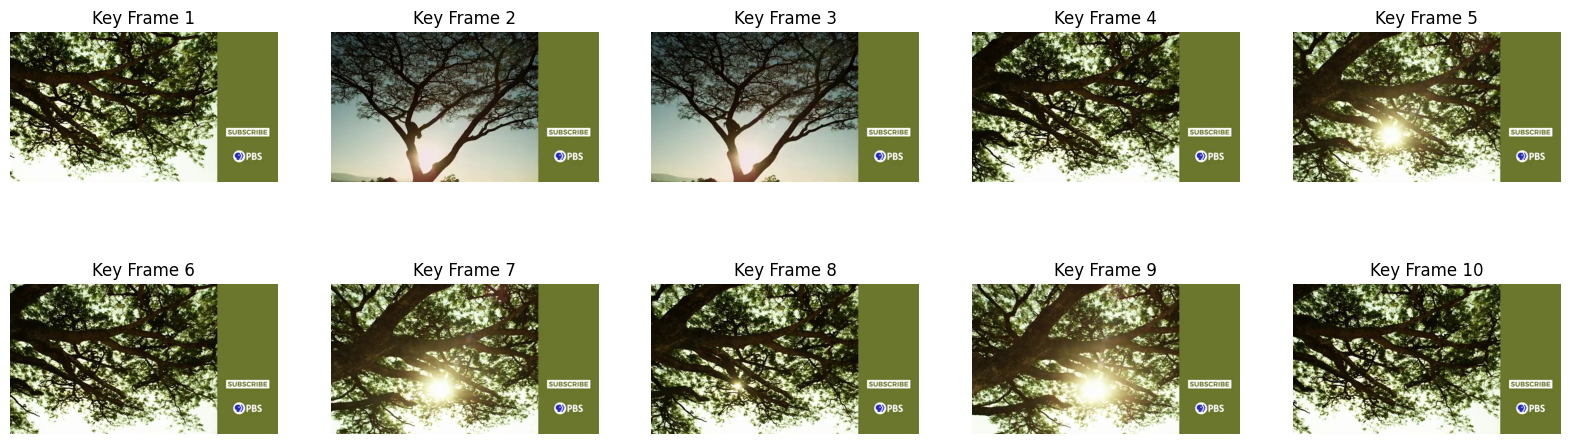


🎬 Visual Summary of Key Moments:

Frame 351 (importance=0.257)
Frame 371 (importance=0.259)
Frame 370 (importance=0.262)
Frame 354 (importance=0.269)
Frame 356 (importance=0.273)
Frame 353 (importance=0.280)
Frame 357 (importance=0.287)
Frame 355 (importance=0.309)
Frame 358 (importance=0.313)
Frame 352 (importance=0.315)


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

# =============================
# Compute Frame Importance
# =============================
def compute_importance(embs):
    """
    Estimate how unique each frame is using cosine similarity.
    Frames less similar to others are more important.
    """
    sim_matrix = torch.matmul(embs, embs.T)
    sim_scores = sim_matrix.mean(dim=1)
    importance = 1 - (sim_scores / sim_scores.max())  # lower similarity → more unique
    return importance.cpu().numpy()

importance_weights = compute_importance(clip_embs)
print(f"[INFO] Computed importance for {len(importance_weights)} frames.")

# =============================
# Select Top Key Frames
# =============================
def select_keyframes(frames, weights, top_k=10):
    idxs = np.argsort(weights)[-top_k:]  # top unique frames
    key_frames = [frames[i] for i in idxs]
    return key_frames, idxs

key_frames, key_idxs = select_keyframes(frames, importance_weights, top_k=10)
print(f"[INFO] Selected {len(key_frames)} key frames.")

# =============================
# Visualize Key Frames
# =============================
plt.figure(figsize=(20, 6))
for i, frame in enumerate(key_frames):
    plt.subplot(2, 5, i+1)
    plt.imshow(frame)
    plt.axis("off")
    plt.title(f"Key Frame {i+1}")
plt.show()

# =============================
# Generate Visual Summary
# =============================
# Instead of text, we print timestamps or relative positions
summary_info = [f"Frame {idx} (importance={importance_weights[idx]:.3f})"
                for idx in key_idxs]
print("\n🎬 Visual Summary of Key Moments:\n")
print("\n".join(summary_info))


In [ ]:
# ==========================================
# CLIP-Based Video Visual Summarizer (No Audio)
# ==========================================
import torch
import torch.nn.functional as F
import clip
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

# 1. Load CLIP model

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# 2. Frame extraction

def extract_frames(video_path, stride=10):
    cap = cv2.VideoCapture(video_path)
    frames, times = [], []
    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx % stride == 0:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            times.append(cap.get(cv2.CAP_PROP_POS_MSEC))
        idx += 1
    cap.release()
    print(f"[INFO] Extracted {len(frames)} frames.")
    return frames, times

# 3. Get CLIP embeddings

def get_clip_embeddings(frames):
    embs = []
    with torch.no_grad():
        for f in tqdm(frames, desc="Encoding frames with CLIP"):
            img = clip_preprocess(Image.fromarray(f)).unsqueeze(0).to(device)
            feat = clip_model.encode_image(img)
            feat = F.normalize(feat, dim=-1)
            embs.append(feat)
    embs = torch.cat(embs, dim=0)
    print(f"[SUCCESS] Generated embeddings of shape: {embs.shape}")
    return embs

# 4. Select key frames (by uniqueness)

def select_keyframes(frames, embs, top_k=10):
    sim = embs @ embs.T
    uniqueness = 1 - sim.mean(dim=1)
    idx = uniqueness.topk(top_k).indices.cpu().numpy()
    keyframes = [frames[i] for i in idx]
    return keyframes, uniqueness[idx], idx

# 5. Describe each key frame using CLIP text prompts

def describe_frame(frame):
    prompt_texts = [
        "a lion chasing a wildebeest",
        "a lion attacking its prey",
        "a lion eating meat",
        "a lion hunting with its pride",
        "a wildebeest running away",
        "a fight between predator and prey",
        "a calm savannah with animals",
        "a lion resting after a hunt",
        "a group of lions watching prey",
        "a herd of wildebeests moving together"
    ]

    with torch.no_grad():
        text_tokens = clip.tokenize(prompt_texts).to(device)
        text_embs = clip_model.encode_text(text_tokens)
        text_embs = F.normalize(text_embs, dim=-1)

        img = clip_preprocess(Image.fromarray(frame)).unsqueeze(0).to(device)
        img_emb = clip_model.encode_image(img)
        img_emb = F.normalize(img_emb, dim=-1)

        sims = (img_emb @ text_embs.T).squeeze(0)
        best_idx = sims.argmax().item()
        return prompt_texts[best_idx]

# 6. Summarize video visually

def summarize_video(video_path, stride=15, top_k=10):
    frames, _ = extract_frames(video_path, stride)
    embs = get_clip_embeddings(frames)
    keyframes, importance, idx = select_keyframes(frames, embs, top_k)

    print("\n🎬 Visual Summary of Key Moments:\n")
    captions = []
    for i, (f, imp, frame_idx) in enumerate(zip(keyframes, importance, idx)):
        desc = describe_frame(f)
        captions.append(desc)
        print(f"Frame {frame_idx:03d} (importance={imp:.3f}) → {desc}")

    print("\n🧠 Final Text Summary:")
    summary = " ".join(sorted(set(captions), key=captions.index))
    print(summary)
    return summary

# 7. Run the pipeline

video_path = "/content/Lion vs. Wildebeest_ How Lions Hunt as a Pride (1).mp4"
summary = summarize_video(video_path, stride=15, top_k=10)


[INFO] Extracted 376 frames.


Encoding frames with CLIP: 100%|██████████| 376/376 [01:38<00:00,  3.82it/s]


[SUCCESS] Generated embeddings of shape: torch.Size([376, 512])

🎬 Visual Summary of Key Moments:

Frame 352 (importance=0.411) → a calm savannah with animals
Frame 358 (importance=0.410) → a calm savannah with animals
Frame 355 (importance=0.406) → a calm savannah with animals
Frame 357 (importance=0.387) → a calm savannah with animals
Frame 353 (importance=0.380) → a calm savannah with animals
Frame 356 (importance=0.375) → a calm savannah with animals
Frame 354 (importance=0.371) → a calm savannah with animals
Frame 370 (importance=0.365) → a calm savannah with animals
Frame 371 (importance=0.363) → a calm savannah with animals
Frame 351 (importance=0.361) → a calm savannah with animals

🧠 Final Text Summary:
a calm savannah with animals


In [11]:
!pip install scenedetect[opencv] opencv-python-headless tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.9/130.9 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.0
    Uninstalling click-8.3.0:
      Successfully uninstalled click-8.3.0


In [14]:
import cv2, numpy as np, torch
import torch.nn.functional as F
from tqdm import tqdm
from scenedetect import VideoManager, SceneManager
from scenedetect.detectors import ContentDetector
from PIL import Image

# assume clip_model, clip_preprocess, device already loaded:
# clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

def detect_scenes(video_path):
    """Return list of (start_frame, end_frame) for each detected scene/shot."""
    video_manager = VideoManager([video_path])
    scene_manager = SceneManager()
    scene_manager.add_detector(ContentDetector(threshold=27.0))  # adjust threshold if needed
    video_manager.set_downscale_factor()  # default: autodetect
    video_manager.start()
    scene_manager.detect_scenes(frame_source=video_manager)
    scene_list = scene_manager.get_scene_list()
    # scene_list: list of (start_time, end_time) as FrameTime; convert to frames
    scenes_frames = [(int(s[0].get_frames()), int(s[1].get_frames())) for s in scene_list]
    video_manager.release()
    return scenes_frames
def frame_at(cap, frame_no):
    """Safely grab a specific frame from a cv2.VideoCapture."""
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
    ret, frame = cap.read()
    if not ret or frame is None:
        return None
    return frame

def pick_action_frame_in_shot(cap, start_f, end_f, max_checks=10):
    step = max(1, (end_f - start_f) // max_checks)
    best_score, best_frame, best_idx = -1, None, start_f
    for f_idx in range(start_f, end_f, step):
        f = frame_at(cap, f_idx)
        if f is None:
            continue
        g = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
        nxt = f_idx + step
        f2 = frame_at(cap, nxt)
        if f2 is None:
            continue
        g2 = cv2.cvtColor(f2, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(g, g2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag = np.mean(np.sqrt(flow[...,0]**2 + flow[...,1]**2))
        if mag > best_score:
            best_score, best_frame, best_idx = mag, f, f_idx
    return best_idx, best_frame, best_score


def extract_keyframes_by_scenes(video_path, top_k_perc=0.2, max_keyframes=None):
    """
    1) detect scenes
    2) pick one high-motion frame inside each scene (action-sensitive)
    3) return list of frames (RGB), frame indices, timestamps (ms), motion scores
    """
    scenes = detect_scenes(video_path)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    collected = []
    for (s_f, e_f) in scenes:
        # ensure valid range
        if e_f <= s_f:
            continue
        bfno, bframe, bscore = pick_action_frame_in_shot(cap, s_f, e_f, max_checks=40)
        if bframe is None:
            continue
        rgb = cv2.cvtColor(bframe, cv2.COLOR_BGR2RGB)
        timestamp_ms = cap.get(cv2.CAP_PROP_POS_MSEC) if bfno is None else (bfno / fps * 1000.0)
        collected.append({"frame_no": bfno, "frame": rgb, "score": bscore, "time_ms": timestamp_ms})
    cap.release()
    # if many scenes, limit to max_keyframes by selecting highest motion
    if max_keyframes is None:
        # by default, keep top 20% of scenes
        max_keep = max(1, int(len(collected) * top_k_perc))
    else:
        max_keep = max_keyframes
    collected_sorted = sorted(collected, key=lambda x: x["score"], reverse=True)[:max_keep]
    return collected_sorted

# Batching helper for CLIP encoding
def encode_frames_clip(frames_list, batch_size=32):
    """
    frames_list: list of np.uint8 RGB images
    returns: torch tensor [N, D] on device
    """
    tensors = []
    with torch.no_grad():
        for i in range(0, len(frames_list), batch_size):
            batch_imgs = frames_list[i:i+batch_size]
            proc = torch.stack([clip_preprocess(Image.fromarray(img)) for img in batch_imgs]).to(device)
            feats = clip_model.encode_image(proc)  # [B, D]
            feats = F.normalize(feats, dim=-1)
            tensors.append(feats.cpu())
    return torch.cat(tensors, dim=0).to(device)

# Example: use in your pipeline
video_path = "/content/Lion vs. Wildebeest_ How Lions Hunt as a Pride (1).mp4"
collected = extract_keyframes_by_scenes(video_path, top_k_perc=0.5, max_keyframes=20)  # tune
frames_rgb = [c["frame"] for c in collected]
frame_nos = [c["frame_no"] for c in collected]
scores = np.array([c["score"] for c in collected])

print(f"[INFO] Selected {len(frames_rgb)} candidate keyframes from scenes.")

# Encode via CLIP in one batch (or small batches)
from PIL import Image
embs = encode_frames_clip(frames_rgb, batch_size=16)  # [N,512]

# Now you can compute importance using embeddings (as before) or directly trust motion scores.
# Example: combine CLIP uniqueness + motion score:
sim = embs @ embs.T
unique = 1 - sim.mean(dim=1).cpu().numpy()
# normalize both signals
unique_n = (unique - unique.min()) / (unique.max() - unique.min() + 1e-8)
motion_n = (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)
combined = 0.6 * unique_n + 0.4 * motion_n
# final ranking
order = np.argsort(combined)[::-1]
final_frames = [frames_rgb[i] for i in order]
final_scores = combined[order]
final_frame_nos = [frame_nos[i] for i in order]
# Extract top-ranked frames (based on combined_score)

# Print top results
for i, (fn, sc) in enumerate(zip(final_frame_nos, final_scores)):
    print(f"Rank {i+1}: frame {fn}, combined_score={sc:.3f}")


ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 29.970 FPS, resolution: 640 x 360
INFO:pyscenedetect:Detecting scenes...


[INFO] Selected 17 candidate keyframes from scenes.
Rank 1: frame 4468, combined_score=0.694
Rank 2: frame 4758, combined_score=0.640
Rank 3: frame 5636, combined_score=0.600
Rank 4: frame 5185, combined_score=0.541
Rank 5: frame 1455, combined_score=0.511
Rank 6: frame 5382, combined_score=0.507
Rank 7: frame 668, combined_score=0.462
Rank 8: frame 5473, combined_score=0.461
Rank 9: frame 4676, combined_score=0.378
Rank 10: frame 4587, combined_score=0.348
Rank 11: frame 276, combined_score=0.328
Rank 12: frame 1615, combined_score=0.320
Rank 13: frame 2359, combined_score=0.299
Rank 14: frame 2596, combined_score=0.279
Rank 15: frame 5263, combined_score=0.276
Rank 16: frame 5607, combined_score=0.228
Rank 17: frame 5532, combined_score=0.215


In [16]:
collected_sorted = sorted(collected, key=lambda x: x["combined_score"], reverse=True)
top_keyframes = [c["frame"] for c in collected_sorted[:5]]  # choose top 5 keyframes


KeyError: 'combined_score'

In [20]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image

# Load BLIP model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda" if torch.cuda.is_available() else "cpu")

# Extract top 5 keyframes for captioning (you can adjust)
top_k = 17
top_keyframes = [final_frames[i] for i in range(len(final_frames))]

captions = []
for i, f in enumerate(top_keyframes):
    inputs = processor(Image.fromarray(f), return_tensors="pt").to(model.device)
    out = model.generate(**inputs, max_new_tokens=50)
    caption = processor.decode(out[0], skip_special_tokens=True)
    captions.append(caption)
    print(f"[Caption {i+1}] {caption}")

print("\n🧠 Generated Frame-level Captions:")
print("\n".join(f"- {cap}" for cap in captions))


[Caption 1] a close up of a horse ' s face
[Caption 2] a group of lions walking through a field
[Caption 3] a black square with a white border
[Caption 4] a man is walking in the dark
[Caption 5] a zebra is walking through the tall grass
[Caption 6] a tree with the sun shining through it
[Caption 7] a lion walking through a field of tall grass
[Caption 8] a tree with the sun shining through it
[Caption 9] a herd of wildes in the bush
[Caption 10] a close up of a wilde cow
[Caption 11] two rhinos are walking through the tall grass
[Caption 12] a deer is walking through the tall grass
[Caption 13] a large brown animal
[Caption 14] a leopard is running through the brush in the wild
[Caption 15] a field with a tree in the middle of it
[Caption 16] a tree with the sun shining through it
[Caption 17] a cat is sitting in a tree

🧠 Generated Frame-level Captions:
- a close up of a horse ' s face
- a group of lions walking through a field
- a black square with a white border
- a man is walking 

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "tiiuae/falcon-7b-instruct"  # fully open model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

# Combine your BLIP captions
prompt = "Summarize the following captions into a short coherent paragraph:\n" + "\n".join(captions)

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=200)
summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("🧠 Video Summary:\n", summary)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

NameError: name 'captions' is not defined